# Voice Classification By Yatharth Jain(yj596@snu.edu.in)

# Performance Metrics Used

1. Accuracy = Correct Predictions / Total Predictions

2. Sensitivity/Recall refers to the true positive rate and summarizes how well the positive class was predicted.

Recall = (True Positive) / (True Positive + False Negative)

3. Precision summarizes the fraction of examples assigned the positive class that belong to the positive class.

Precision = (True Positives) / (True Positives + False Positives).

4. Precision and recall can be combined into a single score that seeks to balance both concerns, called the F-score and is a popular metric for classification .

F-Measure = (2 * Precision * Recall) / (Precision + Recall)

5. Specificity - Specificity is the complement to sensitivity, or the true negative rate, and summarizes how well the negative class was predicted.

Specificity = (True Negative) / (False positive + True Negative)

6. A ROC curve is a diagnostic plot for summarizing the behavior of a model by calculating the false positive rate and true positive rate for a set of predictions by the model under different thresholds.
The area under the ROC curve can be calculated and provides a single score to summarize the plot that can be used to compare models. A no skill classifier will have a score of 0.5, whereas a perfect classifier will have a score of 1.0.

# Importing Modules

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,accuracy_score,precision_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

Importing Dataset

In [2]:
data=pd.read_csv('voice-classification.csv')
print(data.head())

   meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  

Analysis of Data

In [3]:
df=data.copy()
print(df.index)

RangeIndex(start=0, stop=3168, step=1)


In [4]:
print(df.shape)

(3168, 21)


Hence, there are total 3168 observations along with 20 features and 1 decision variable.

In [5]:
print(df.columns)

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')


In [6]:
print("Total number of samples: {}".format(df.shape[0]))
print("Number of male: {}".format(df[df.label == 'male'].shape[0]))
print("Number of female: {}".format(df[df.label == 'female'].shape[0]))

Total number of samples: 3168
Number of male: 1584
Number of female: 1584


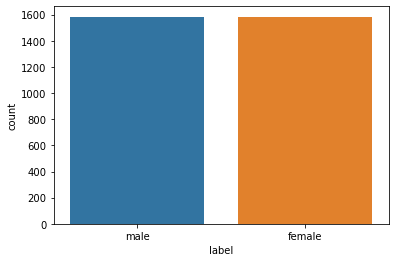

In [7]:
sns.countplot(data=df,x='label')

It seems that the dataset is balanced as we have equal number of males and females.

Now, checking for missing values. If found any, I will replace that with the mean of the column.

In [8]:
print(df.isnull().any())

meanfreq    False
sd          False
median      False
Q25         False
Q75         False
IQR         False
skew        False
kurt        False
sp.ent      False
sfm         False
mode        False
centroid    False
meanfun     False
minfun      False
maxfun      False
meandom     False
mindom      False
maxdom      False
dfrange     False
modindx     False
label       False
dtype: bool


Since there are no missing values no need of any replacement.

Encoding the 'label' column of the dataset. 'male'-> 1 ; 'Female'-> 0 

In [9]:
temp = []
for i in df.label:
    if i == 'male':
        temp.append(1)
    else:
        temp.append(0)
df['label'] = temp

# Correlation between features

To analyse correlation between different features I have plotted a heat map which gives better visualization of correlation between different features.

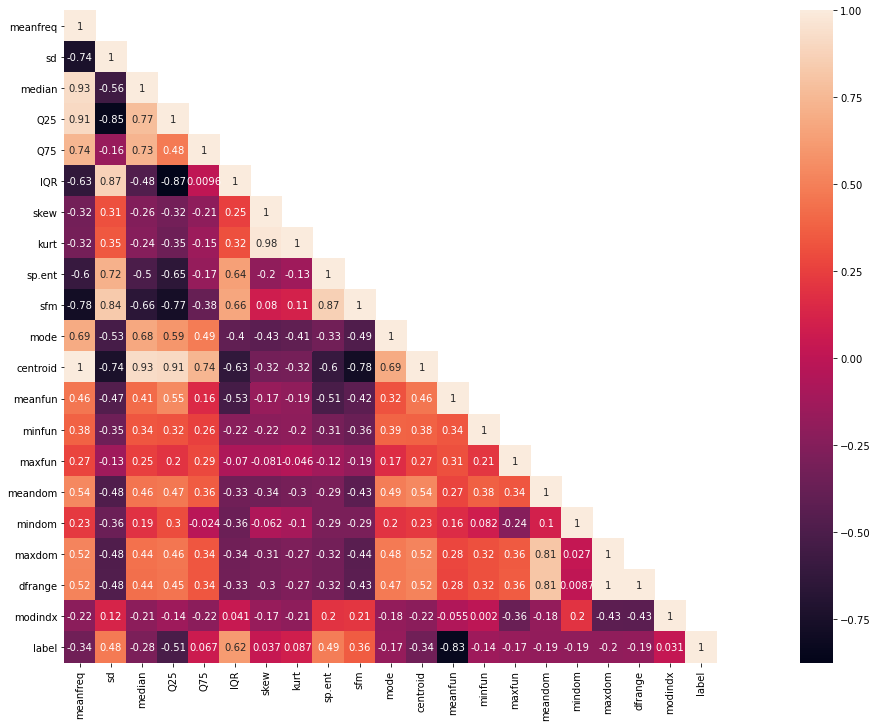

In [11]:
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

Here I can see that 'meanfreq' and 'centroid' have a perfect correlation, hence I can drop anyone of them but after a close look I find that 'centroid' in general has a high degree of corelation with most of the other features.
Hence, I will drop 'centroid'. 
Similarly, 'sd' is highly positively related to 'sfm' and so is 'sp.ent' to 'sd'.
'kurt' and 'skew' are also highly corelated. 'meanfreq' is highly related to 'medain' as well as 'Q25'. 'IQR' is highly corelated to 'sd'.
Hence, finally I am tempted towrds dropping 'skew', 'kurt', 'mindom', 'maxdom', 'meanfreq','IQR' but I will decide on this after looking at the plot of the features against target.
We can also use dimensionality reduction techniques like Principal Component Analysis(PCA) to reduce our feature space. 

# Plots of few features against Target

General function for plotting

In [12]:
def plot_against_target(feature):
    sns.factorplot(data=df,y=feature,x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(7,7)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


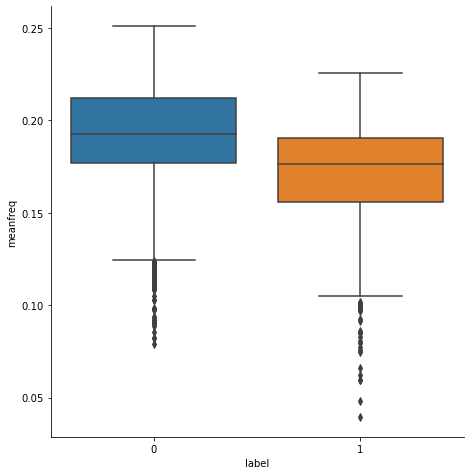

In [13]:
plot_against_target('meanfreq') 

The boxplot depicts that the females in genral have higher mean frequencies than their male counterparts.

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


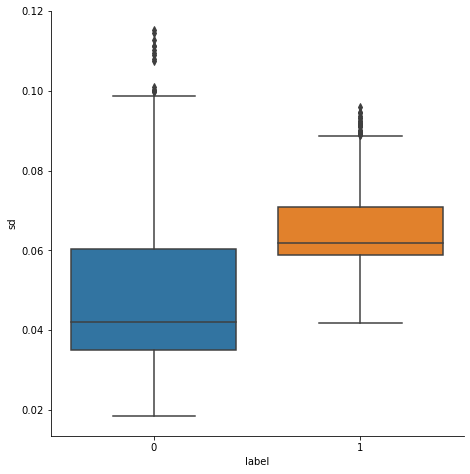

In [14]:
plot_against_target('sd')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


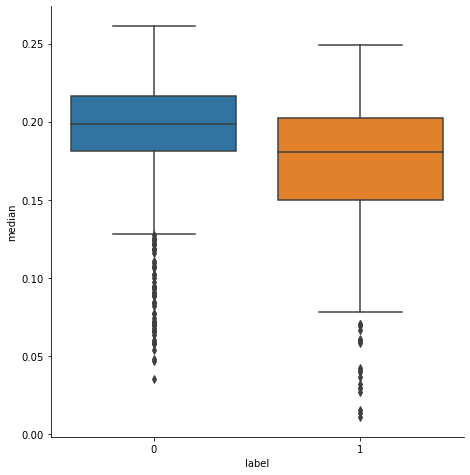

In [15]:
plot_against_target('median')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


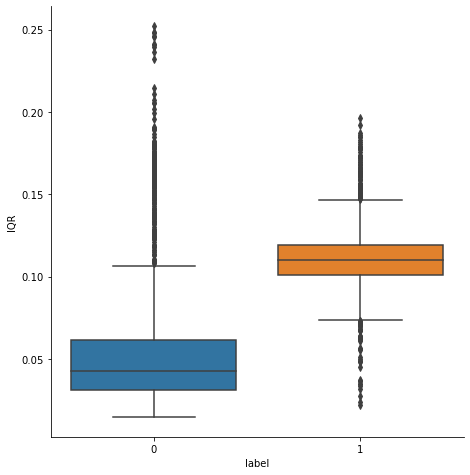

In [16]:
plot_against_target('IQR')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


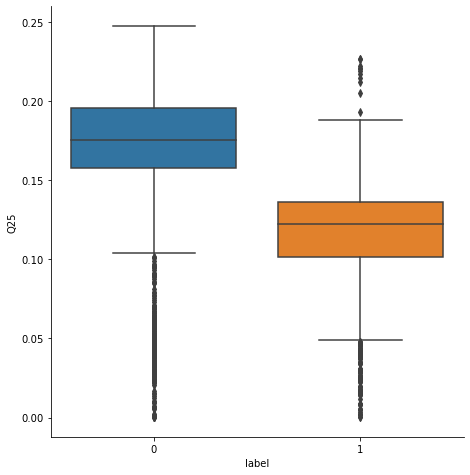

In [17]:
plot_against_target('Q25')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


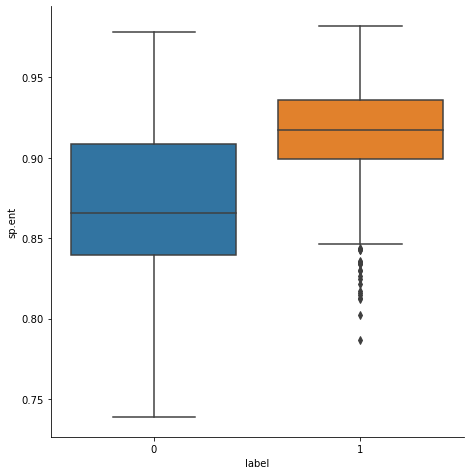

In [18]:
plot_against_target('sp.ent')

Here I can see a difference betweem 'IQR' of males and females.

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


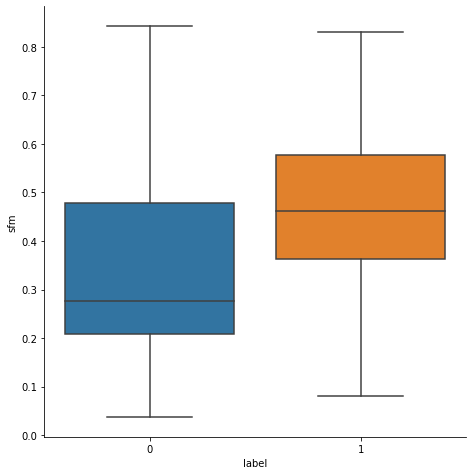

In [19]:
plot_against_target('sfm') 

C:\Users\hp\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


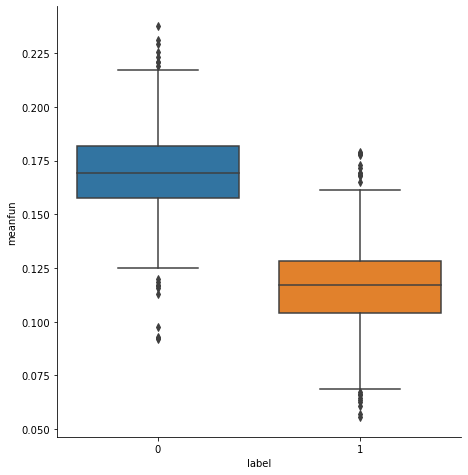

In [20]:
plot_against_target('meanfun')

Here also there is a difference in 'meanfun' of males and females.

As I mentioned earlier I am dropping some columns as I personally find them redundant.

In [21]:
temp_df=df.copy()
temp_df.drop(['skew','kurt','mindom','maxdom'],axis=1,inplace=True) 
print(temp_df.head(10))

   meanfreq        sd    median       Q25       Q75       IQR    sp.ent  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  0.893369   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  0.892193   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  0.846389   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374  0.963322   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325  0.971955   
5  0.132786  0.079557  0.119090  0.067958  0.209592  0.141634  0.963181   
6  0.150762  0.074463  0.160106  0.092899  0.205718  0.112819  0.967573   
7  0.160514  0.076767  0.144337  0.110532  0.231962  0.121430  0.959255   
8  0.142239  0.078018  0.138587  0.088206  0.208587  0.120381  0.970723   
9  0.134329  0.080350  0.121451  0.075580  0.201957  0.126377  0.975246   

        sfm      mode  centroid   meanfun    minfun    maxfun   meandom  \
0  0.491918  0.000000  0.059781  0.084279  0.015702  0.275862  0.007812   
1  0.513724  0.000000  0

Modifying Median column according to standard.

In [22]:
#Modifying features according to standard
# Mean-Mode=3*(Mean-Meadian)
#modifying median column
temp_df['meanfreq']=temp_df['meanfreq'].apply(lambda x:x*2)
temp_df['median']=temp_df['meanfreq']+temp_df['mode']
temp_df['median']=temp_df['median'].apply(lambda x:x/3)
temp_df.head(10)

,meanfreq,sd,median,Q25,Q75,IQR,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,dfrange,modindx,label
0,0.119562,0.064241,0.039854,0.015071,0.090193,0.075122,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.000000,0.000000,1
1,0.132017,0.067310,0.044006,0.019414,0.092666,0.073252,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.046875,0.052632,1
2,0.154631,0.083829,0.051544,0.008701,0.131908,0.123207,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.046512,1
3,0.302456,0.072111,0.128778,0.096582,0.207955,0.111374,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.554688,0.247119,1
4,0.270241,0.079146,0.124834,0.078720,0.206045,0.127325,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,5.476562,0.208274,1
5,0.265573,0.079557,0.126043,0.067958,0.209592,0.141634,0.963181,0.738307,0.112555,0.132786,0.110132,0.017112,0.253968,0.298222,2.718750,0.125160,1
6,0.301525,0.074463,0.129240,0.092899,0.205718,0.112819,0.967573,0.762638,0.086197,0.150762,0.105945,0.026230,0.266667,0.479620,5.304688,0.123992,1
7,0.321029,0.076767,0.149784,0.110532,0.231962,0.121430,0.959255,0.719858,0.128324,0.160514,0.093052,0.017758,0.144144,0.301339,0.531250,0.283937,1
8,0.284479,0.078018,0.167861,0.088206,0.208587,0.120381,0.970723,0.770992,0.219103,0.142239,0.096729,0.017957,0.250000,0.336476,2.156250,0.148272,1
9,0.268658,0.080350,0.093452,0.075580,0.201957,0.126377,0.975246,0.804505,0.011699,0.134329,0.105881,0.019300,0.262295,0.340365,4.679688,0.089920,1


# Splitting Dataset

In [45]:
X=temp_df.iloc[:,:-1].values
Y=temp_df.iloc[:,-1].values
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

Normalsing the features

In [46]:
sc_X=StandardScaler()
x_train=sc_X.fit_transform(x_train)
x_test=sc_X.transform(x_test)

A function for plotting ROC curves

In [83]:
def ROC(fpr,tpr,m):
    plt.figure()
    plt.plot([0,1], [0,1], linestyle="--",label='No Skill') # plot random curve
    plt.plot(fpr, tpr, marker='', label=m)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve: "+m)
    plt.legend(loc="lower right")
    # show the plot
    plt.show()

A function for printing various results

In [84]:
def results(y_test,pred):
    cm=confusion_matrix(y_test,pred)
    score= roc_auc_score(y_test, pred)
    print(cm)
    print(f'Testing F1 score is: {f1_score(y_test,pred,average="macro"):.3f}')
    print(f'Testing accuracy is: {accuracy_score(y_test,pred):.3f}')
    print(classification_report(y_test,pred))
    print("AUC_ROC Score: ",score)

# Machine Learning Algorithms with Results

1. Logistic Regression

[[357  10]
 [ 10 415]]
Testing F1 score is: 0.975
Testing accuracy is: 0.975
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       367
           1       0.98      0.98      0.98       425

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792

AUC_ROC Score:  0.9746113159160122


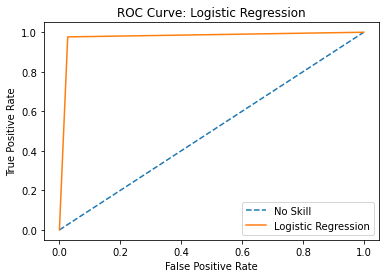

In [85]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
pred=lr.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,'Logistic Regression')

2. kNN Classification

[[360   7]
 [  8 417]]
Testing F1 score is: 0.981
Testing accuracy is: 0.981
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.98      0.98      0.98       425

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792

AUC_ROC Score:  0.9810514505529734


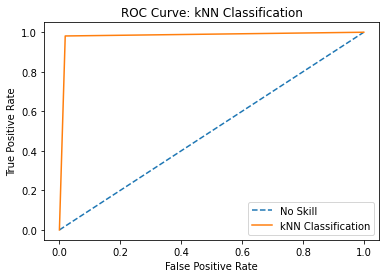

In [86]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
pred=knn.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,'kNN Classification')

3. Linear SVM Classifier

[[358   9]
 [ 10 415]]
Testing F1 score is: 0.976
Testing accuracy is: 0.976
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       367
           1       0.98      0.98      0.98       425

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792

AUC_ROC Score:  0.9759737137361757


C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


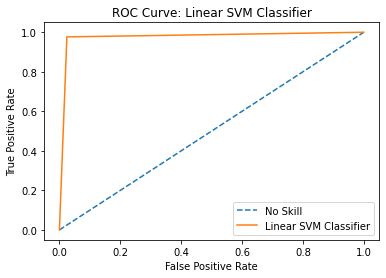

In [87]:
svm=LinearSVC()
svm.fit(x_train,y_train)
pred=svm.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,'Linear SVM Classifier')

4. SVM Classifier with 'rbf' Kernel

[[360   7]
 [  9 416]]
Testing F1 score is: 0.980
Testing accuracy is: 0.980
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.98      0.98      0.98       425

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792

AUC_ROC Score:  0.979874979964738


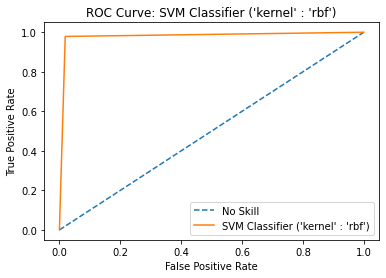

In [88]:
svm=SVC(kernel='rbf')
svm.fit(x_train,y_train)
pred=svm.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,"SVM Classifier ('kernel' : 'rbf')")

5. Decision Tree Classifier

[[360   7]
 [ 18 407]]
Testing F1 score is: 0.968
Testing accuracy is: 0.968
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       367
           1       0.98      0.96      0.97       425

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792

AUC_ROC Score:  0.9692867446706204


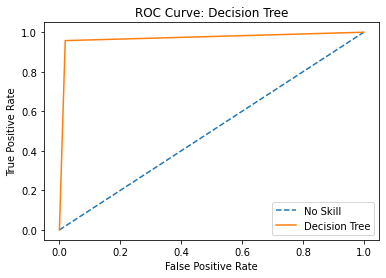

In [89]:
clf_dt=DecisionTreeClassifier()
clf_dt.fit(x_train,y_train)
pred=clf_dt.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,'Decision Tree')

6. Random Forest Classiifer

[[363   4]
 [ 11 414]]
Testing F1 score is: 0.981
Testing accuracy is: 0.981
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       367
           1       0.99      0.97      0.98       425

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792

AUC_ROC Score:  0.9816092322487577


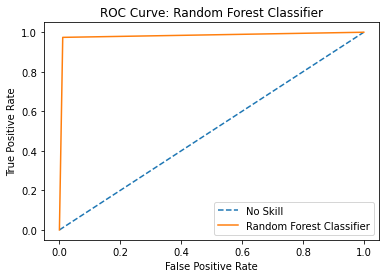

In [90]:
clf_rf=RandomForestClassifier()
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,'Random Forest Classifier')

7. Gradient Boosting Classifier

[[359   8]
 [  8 417]]
Testing F1 score is: 0.980
Testing accuracy is: 0.980
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.98      0.98      0.98       425

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792

AUC_ROC Score:  0.9796890527328098


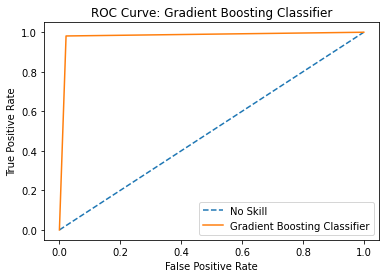

In [91]:
gb=GradientBoostingClassifier()
gb.fit(x_train,y_train)
pred=gb.predict(x_test)
results(y_test,pred)
fpr,tpr, thresholds = roc_curve(y_test,pred)
ROC(fpr,tpr,'Gradient Boosting Classifier')

# K-Fold Cross Validation on all 4 Algorithms

In [92]:
models=[LogisticRegression(),LinearSVC(),SVC(kernel='rbf'),KNeighborsClassifier(),RandomForestClassifier(),
        DecisionTreeClassifier(),GradientBoostingClassifier()]
model_names=['LogisticRegression','LinearSVM','rbfSVM','KNearestNeighbors','RandomForestClassifier','DecisionTree',
             'GradientBoostingClassifier']
acc=[]
d={}
for model in range(len(models)):
    clf=models[model]
    accuracies=cross_val_score(estimator=clf,X=x_train,y=y_train,cv=10)
    acc.append(accuracies.mean())
     
d={'Modelling Algo':model_names,'Accuracy':acc}
acc_frame=pd.DataFrame(d)
print(acc_frame)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

               Modelling Algo  Accuracy
0          LogisticRegression  0.971386
1                   LinearSVM  0.970126
2                      rbfSVM  0.980215
3           KNearestNeighbors  0.976003
4      RandomForestClassifier  0.979382
5                DecisionTree  0.962112
6  GradientBoostingClassifier  0.975586


According to me the best performing algorithm is SVM. Hence, applying grid search to find best parameters.

In [93]:
params_dict={'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100],'kernel':['linear','rbf']}
clf=GridSearchCV(estimator=SVC(),param_grid=params_dict,scoring='accuracy',cv=10)
clf.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [94]:
print(clf.best_score_)

0.9827394248838776


In [95]:
print(clf.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [96]:
print(accuracy_score(clf.predict(x_test),y_test))

0.9797979797979798


In [97]:
print(precision_score(clf.predict(x_test),y_test))

0.9788235294117648


Precision summarizes the fraction of examples assigned the positive class that belong to the positive class.
Precision = (True Positives)/(True Positives + False Positives).
High precision is what we for in a better performing model and here we are getting a precision of about 97.8% which is really good.

So according to me the best performing model on the given dataset is SVM classifier with 'C'=1, 'gamma'=0.1 and 'kernekl'='rbf' as parameters.

---------------------------------------------------------------------------------------THE END--------------------------------------------------------------------------------------------------------------